In [1]:
!pip install pyspark py4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=57eaadd0a9d7441b3929840002432ad8e2b4debc96cc40a418c78e9c7ae3b4de
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [18]:
from pyspark.sql import SparkSession
import  pyspark.sql.functions as fn
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.types import DateType
from pyspark.sql.functions import to_date
from pyspark.sql.functions import col

In [3]:
spark=SparkSession.builder.getOrCreate()

In [4]:
netflix_df = spark.read.csv("/content/Netflix.csv", header=True, inferSchema=True)

In [5]:
netflix_df.write.parquet("/content/Netflix.parquet")

In [6]:
netflix_df.printSchema()

root
 |-- User ID: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Monthly Revenue: integer (nullable = true)
 |-- Join Date: string (nullable = true)
 |-- Last Payment Date: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Device: string (nullable = true)
 |-- Plan Duration: string (nullable = true)



In [7]:
netflix_df.dtypes

[('User ID', 'int'),
 ('Subscription Type', 'string'),
 ('Monthly Revenue', 'int'),
 ('Join Date', 'string'),
 ('Last Payment Date', 'string'),
 ('Country', 'string'),
 ('Age', 'int'),
 ('Gender', 'string'),
 ('Device', 'string'),
 ('Plan Duration', 'string')]

In [8]:
netflix_df.describe().select("summary","Monthly Revenue").show()

+-------+------------------+
|summary|   Monthly Revenue|
+-------+------------------+
|  count|              2500|
|   mean|           12.5084|
| stddev|1.6868513944775387|
|    min|                10|
|    max|                15|
+-------+------------------+



In [19]:
# Convert 'Join Date' to datetime
netflix_df = netflix_df.withColumn("Join Date", to_date(col("Join Date"), "dd-MM-yy").cast(DateType()))
# Convert 'Last Payment Date' to datetime
netflix_df = netflix_df.withColumn("Last Payment Date", to_date(col("Last Payment Date"), "dd-MM-yy").cast(DateType()))
netflix_df.printSchema()

root
 |-- User ID: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Monthly Revenue: integer (nullable = true)
 |-- Join Date: date (nullable = true)
 |-- Last Payment Date: date (nullable = true)
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Device: string (nullable = true)
 |-- Plan Duration: string (nullable = true)



#**A-** Five conclusions from the data, suported with appropriate graphs

##Distribution of subscription types

In [21]:
subscription_counts= netflix_df.groupBy("Subscription Type").count()
subscription_counts.show()

+-----------------+-----+
|Subscription Type|count|
+-----------------+-----+
|          Premium|  733|
|            Basic|  999|
|         Standard|  768|
+-----------------+-----+



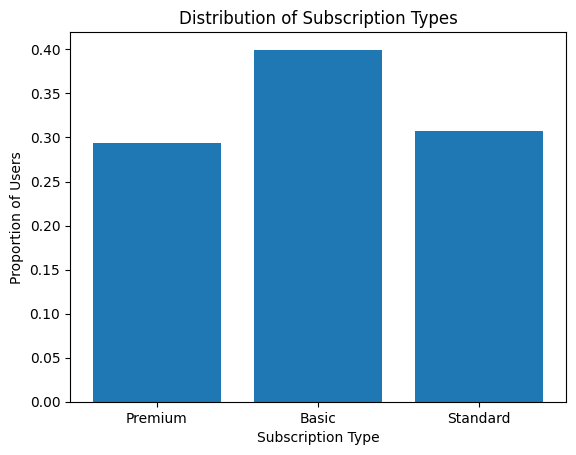

In [20]:
proportions = subscription_counts.withColumn("Proportion", fn.col("count") / netflix_df.count())

proportions_df = proportions.toPandas()

plt.bar(proportions_df["Subscription Type"], proportions_df["Proportion"])
plt.xlabel("Subscription Type")
plt.ylabel("Proportion of Users")
plt.title("Distribution of Subscription Types")
plt.show()

Nearly 40% of users in this dataset have opted for the Basic plan, indicating a preference for lower-cost options.

##Revenue by country

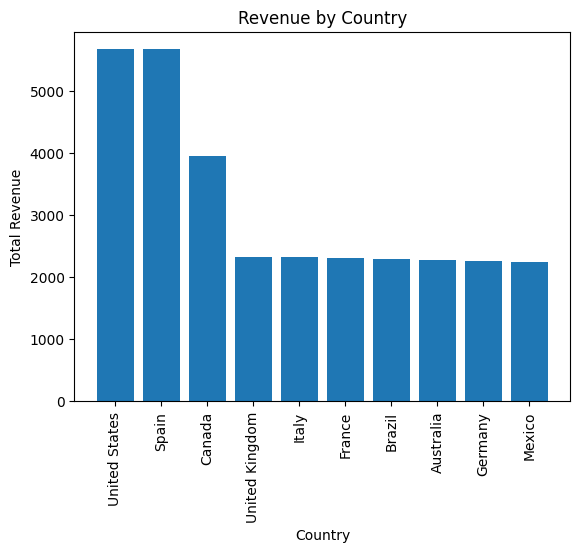

In [11]:
revenue_by_country = netflix_df.groupBy("Country").agg(fn.sum("Monthly Revenue").alias("Total Revenue"))

revenue_df = revenue_by_country.toPandas()
revenue_df = revenue_df.sort_values(by="Total Revenue", ascending=False)

plt.bar(revenue_df["Country"], revenue_df["Total Revenue"])
plt.xlabel("Country")
plt.ylabel("Total Revenue")
plt.title("Revenue by Country")
plt.xticks(rotation=90)
plt.show()

This shows that most users are from either the US or Spain. Additionally, the bar chart shows the most dominating countries and their counts.

##Average revenue per user






In [12]:
arpu_by_type = netflix_df.groupBy("Subscription Type").agg(
    fn.avg("Monthly Revenue").alias("ARPU"), fn.count("User ID").alias("Num Users")
)

# Calculate overall ARPU
overall_arpu = netflix_df.agg(fn.avg("Monthly Revenue")).collect()[0][0]

# Table visualization
print("Average revenue per user by Subscription Type:")
arpu_by_type.show()
print("\nOverall Average revenue per user:", overall_arpu)

Average revenue per user by Subscription Type:
+-----------------+------------------+---------+
|Subscription Type|              ARPU|Num Users|
+-----------------+------------------+---------+
|          Premium|12.590723055934516|      733|
|            Basic|12.481481481481481|      999|
|         Standard|       12.46484375|      768|
+-----------------+------------------+---------+


Overall Average revenue per user: 12.5084


ARPU reveals significant differences in revenue generated by different subscription types. Premium users likely represent a higher value segment, contributing more revenue per month compared to Basic or Standard users. This highlights the importance of attracting and retaining Premium subscribers for increased profitability.



##Count users by age and gender


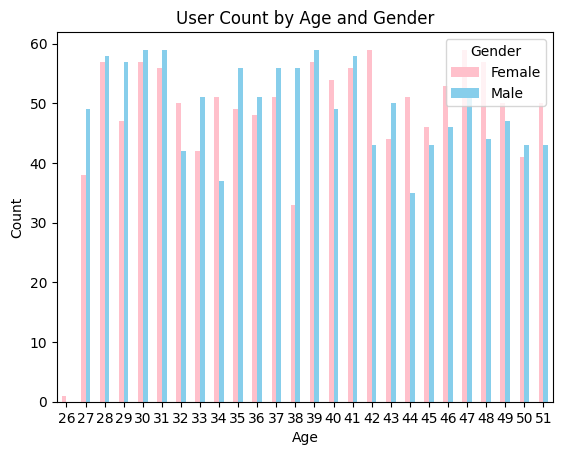

In [13]:
counts_by_age_gender = netflix_df.groupby(["Age","Gender"]).count().orderBy("Age")

# Collect data as Pandas DataFrame for plotting
counts_df = counts_by_age_gender.toPandas()

counts_df = counts_df.pivot_table(values="count", index="Age", columns="Gender")

counts_df.plot(kind="bar", color=["pink", "skyblue"])
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("User Count by Age and Gender")
plt.legend(title="Gender")
plt.xticks(rotation=0)
plt.show()

The graph clearly shows a skewed distribution towards younger age groups, with higher concentrations in their late teens and early twenties. This aligns with trends in digital media consumption and suggests a focus on attracting and retaining younger audiences.

While the overall user base seems balanced, there appears to be a slight gender disparity, with slightly more male users across most age groups. This disparity could be due to various factors like marketing strategies, content preferences, or cultural norms surrounding digital media consumption.

##Average monthly revenue per device type

In [14]:
revenue_per_device = netflix_df.groupBy("Device").agg(fn.avg("Monthly Revenue").alias("Average Revenue"))
revenue_per_device.show()


+----------+------------------+
|    Device|   Average Revenue|
+----------+------------------+
|    Laptop|12.569182389937106|
|    Tablet|12.592417061611375|
|  Smart TV| 12.48360655737705|
|Smartphone| 12.38486312399356|
+----------+------------------+



 Laptops and tablets generate slightly higher average revenue compared to Smart TVs and smartphones, suggesting that these devices might be associated with longer viewing sessions, more content consumption, or potentially higher-tier subscription choices.

#**B-** State what is the most appropriate solution for processing the data and mention the problem.

**Key Considerations:**

*  **Data Size**: Large dataset (exceeding available RAM) necessitates distributed processing with PySpark.

* **Analysis Complexity:** Simple aggregations and visualizations can often be handled with Pandas or SQL. However, complex transformations, machine learning, or handling large datasets favor PySpark.

* **Performance Requirements:** PySpark excels in parallel processing and handling large datasets efficiently.

* **Skillset and Resources**: Assess your team's familiarity with PySpark and available infrastructure for distributed processing.


**Recommendations:**

* **Large dataset, complex analysis, and performance demands:** PySpark is highly suitable.
* **Smaller dataset, simpler analysis:** Pandas or SQL might suffice, potentially offering faster development and less overhead.

#**C-** Mention whether there is any tool, function, or graphs that you used for the first time, what you used it for, how satisfied you were with it, and whether it was effective, or will you try to find an alternative to it?

**pivot_table():**

**Purpose:** Reshapes data for easier analysis, creating a pivot table with aggregated values.

**How I used it**:
To visualize user counts across age groups and genders.


---


**agg():**

**Purpose:** Performs aggregations on grouped data, like sums, averages, counts, etc.

**How I used it:**
* To calculate total revenue per country (fn.sum("Monthly Revenue")).
* To compute average revenue per user (fn.avg("Monthly Revenue")).

#**D-** What is the most appropriate programming language for this project and was pyspark the best solution and why?

**PySpark's Advantages:**

* Handles large datasets efficiently with distributed processing.

*   Offers a Pythonic interface, leveraging Python's readability and libraries.
*   Integrates with SQL for data querying and manipulation.
* Supports diverse analysis techniques (aggregations, visualizations, machine learning).

**Alternatives for Smaller Datasets or Simpler Analyses:**


*   Pandas: Excels in data manipulation and analysis on a single machine.
*   SQL: Effective for querying and filtering structured data.

**Key Factors for Language Choice:**

* Dataset size and complexity.
* Analysis requirements.
* Team skillset and preferences.
* Available resources and infrastructure.